# Cyypto Correlation & Cointegration strategy development

In [18]:
import numpy as np
import pandas as pd
import requests
import schedule
import time
from myconfig import api_key, secret
import ccxt
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data Import

In [236]:
binance = ccxt.binance({'options': {'enableRateLimit': True}})
binance_perp = ccxt.binanceusdm({'options': {'enableRateLimit': True}})

pd.options.mode.chained_assignment = None 

exchange = ccxt.binance()
timeframe = '1h'

def get_ohlcv_data(symbol, since, until):
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, since, until)
    return pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

def get_past_n_months_data(symbol, n_months):
    current_time = int(time.time() * 1000)
    past_n_months = current_time - (n_months * 30 * 24 * 60 * 60 * 1000)
    dfs = []
    for i in range(n_months, 0, -1):
        start = current_time - (i * 30 * 24 * 60 * 60 * 1000)
        end = current_time - ((i - 1) * 30 * 24 * 60 * 60 * 1000)
        df = get_ohlcv_data(symbol, start, end)
        dfs.append(df)
    return pd.concat(dfs)


go_back = 0 # 0 for current, 1 for 30 days (1 month) back, 2 for 2 months back etc.
default_lookback = 9 # 9 for 10 months back and 1 month test set, 10 for 11 months back, etc.
months_back = default_lookback + (1*go_back) # 9 for 10 months back, 10 for 11 months back, etc.
days_back = 0 + (go_back*30) # 0 for today, 30 for 30 days back, etc.

#symbols = ['GALUSDT', 'REIUSDT']
symbols = ['ACHUSDT', 'KP3RUSDT']

dfs = []
for symbol in symbols:
    try:
        df = get_past_n_months_data(symbol, months_back)
        df = df[['timestamp', 'close']]
        df.rename(columns={'timestamp': 'date', 'close': symbol}, inplace=True)
        dfs.append(df)
    except Exception as e:
        print(f"Failed to retrieve data for {symbol}: {e}")

if dfs:
    d_=[]
    val = dfs.copy()

    for v in val:
            
        d = v.reset_index(drop=True)
        d_.append(d)

    df = pd.concat(d_, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.dropna(inplace=True)
    df = df[~df.date.duplicated(keep='first')]
    
df.set_index('date', inplace=True)
df

,ACHUSDT,KP3RUSDT
date,,
2022-05-23 14:00:00,0.02101,157.30
2022-05-23 15:00:00,0.02164,158.51
2022-05-23 16:00:00,0.02117,157.47
2022-05-23 17:00:00,0.02062,155.53
2022-05-23 18:00:00,0.02131,152.91
...,...,...
2023-02-17 09:00:00,0.02203,82.30
2023-02-17 10:00:00,0.02148,82.24
2023-02-17 11:00:00,0.02173,82.41


In [243]:
gal = df['GALUSDT']
rei = df['REIUSDT']
copy_df = df.copy()

In [240]:

prices_df = copy_df.copy() # stock copy incase of changes

## Correlation & Cointegration

Correlation and cointegration are both measures of the relationship between two variables. In the case of crypto prices between GALUSDT and REIUSDT, they can be used to determine whether these two assets move in tandem or if there are any long-term relationships between them.

First, let's define what correlation and cointegration are:

Correlation measures the degree to which two variables move in relation to each other. It ranges from -1 to 1, where -1 represents a perfect negative correlation (when one asset goes up, the other goes down), 0 represents no correlation, and 1 represents a perfect positive correlation (when one asset goes up, the other goes up).

Cointegration, on the other hand, measures the long-term relationship between two variables, even if they are not perfectly correlated in the short term. It is used to determine whether there is a common underlying trend that affects both assets.

Now, let's look at how to calculate these measures using pandas df and formulas:

Correlation:

In [25]:
corr = gal.corr(rei)
print(f'Correlation between GALUSDT and REIUSDT: {corr:.2f}')

Correlation between GALUSDT and REIUSDT: 0.86


In [26]:
diff = gal - rei
diff

date
2022-05-23 10:00:00    6.3633
2022-05-23 11:00:00    6.4250
2022-05-23 12:00:00    6.3076
2022-05-23 13:00:00    6.3281
2022-05-23 14:00:00    6.3011
                        ...  
2023-02-17 05:00:00    2.1397
2023-02-17 06:00:00    2.1512
2023-02-17 07:00:00    2.1432
2023-02-17 08:00:00    2.1599
2023-02-17 09:00:00    2.1562
Length: 6480, dtype: float64

In [125]:
sm.tsa.stattools.coint(gal, rei)

(-4.908394330903849,
 0.00024177880955805354,
 array([-3.89813117, -3.33707322, -3.04510467]))

In [126]:
result = sm.tsa.stattools.coint(gal, rei)
print(f"P-value: {result[1]:.4f}")

P-value: 0.0002


A p-value of less than 0.05 indicates that there is strong evidence of cointegration.

Finally, let's plot the data to visualize the relationship between the two assets:



# Difference $∆yt = y_{t} − y_{t−1}$

In time series analysis, ∆yt = yt − yt−1 represents the first difference of a time series, which is calculated by subtracting the previous value of the time series from the current value. This is often used to remove the trend component of the time series and make it stationary.

To calculate the first difference of a time series in pandas, we can use the diff() method, which computes the difference between consecutive elements in the DataFrame. Here's an example:


<AxesSubplot:xlabel='date'>

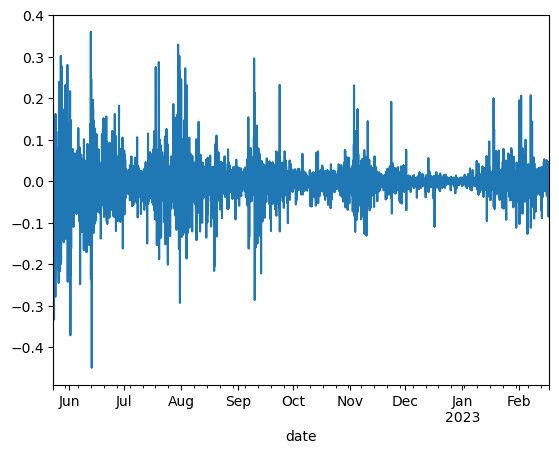

In [127]:
gal.diff().plot()

<AxesSubplot:xlabel='date'>

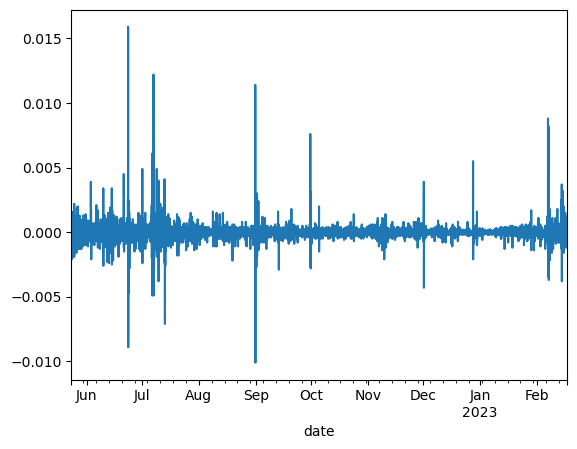

In [128]:
rei.diff().plot()

In time series analysis, one of the assumptions of many statistical methods is that the time series data is stationary, meaning that the statistical properties of the data do not change over time. For example, the mean, variance, and autocorrelation of the data should be constant over time. However, many real-world time series data are not stationary, and they may exhibit trends or seasonality that make it difficult to analyze them using statistical methods.

One way to address the non-stationarity of time series data is to use the first difference of the series, which is calculated by subtracting the previous value of the series from the current value. This can help to remove the trend or seasonality component of the series and make it stationary. Once the series is stationary, we can use standard statistical methods to analyze it, including calculating the correlation between two time series.

In [129]:
# Calculate the correlation between the first difference of the two series
diff_rei = rei.diff().dropna()
diff_gal = gal.diff().dropna()

corr_diff = diff_gal.corr(diff_rei)
print(f'Correlation between the first difference of GALUSDT and REIUSDT: {corr_diff:.2f}')

Correlation between the first difference of GALUSDT and REIUSDT: 0.22


In general, the difference between `gal.corr(rei)` and `diff_gal.corr(diff_rei)` will depend on the specific properties of the data. If the two time series are already stationary and do not exhibit any trend or seasonality, then the correlation coefficient computed using the original data `(gal.corr(rei))` may be a good estimate of the true correlation between the two series. However, if the two time series are non-stationary and exhibit trend or seasonality, then the correlation coefficient computed using the first difference of the data `(diff_gal.corr(diff_rei))` may be a more accurate estimate of the true correlation between the two series.

## Integrated order $I(p)$

A time series is called integrated of order $p$, denoted as $I(p)$, if the time series obtained by differencing the time series $p$ times is weakly stationary, while the time series obtained by differencing the time series $p-1$ times is not weakly stationary.

This means that the original time series is non-stationary and exhibits some trend or seasonality. By taking the first difference of the time series, we remove the trend or seasonality in the series and obtain a new series. If this new series is still non-stationary and exhibits some trend or seasonality, we can take the first difference of the new series again to obtain a new series. We repeat this process p times until we obtain a stationary time series.

The notation $I(p)$ indicates that we need to take $p$ differences of the time series to obtain a stationary series. The parameter $p$ is also called the order of integration. If the original time series is already stationary (i.e., it does not exhibit trend or seasonality), then $p=0$, and we say that the time series is $I(0)$.

In [130]:
from statsmodels.tsa.stattools import adfuller

close_df = pd.read_csv('prices_large.csv', index_col=0, parse_dates=True)
# Create a new DataFrame to store the integrated orders
integrated_orders = pd.DataFrame(columns=['symbol', 'int_order'])

sym = []
int_ord = []

# Iterate over the columns and calculate the integrated order
for col in close_df.columns:
    # Calculate the first difference of the time series
    diff1_ts = close_df[col].diff().dropna()
    
    # Test for stationarity using the Augmented Dickey-Fuller test
    adf_result = adfuller(diff1_ts)
    
    # Determine the order of integration
    int_order = 0
    while adf_result[1] > 0.05:
        int_order += 1
        diff1_ts = diff1_ts.diff().dropna()
        adf_result = adfuller(diff1_ts)
    
    # Add the symbol and integrated order to the DataFrame
    sym.append(col)
    int_ord.append(int_order)

#integrated_orders
IO_df = pd.DataFrame({'symbols' : sym, 'integrated_order' : int_ord})
IO_df[IO_df['integrated_order'] > 0]

,symbols,integrated_order


### Cointegration function:

The coint() function returns a tuple with several values, including the t-statistic, p-value, and critical values. The p-value indicates the significance of the test. If the p-value is less than the chosen significance level (typically 0.05), we can reject the null hypothesis of no cointegration and conclude that the two series are cointegrated. If the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that the two series are not cointegrated.

If the test for cointegration is significant, it means that there is a linear combination of the two series that is stationary. In other words, there is a relationship between the two series that is not just due to chance, but rather reflects a long-term relationship that can be exploited for trading or forecasting purposes.

In [ ]:
coint_result = sm.tsa.stattools.coint(gal, rei)

print('t-statistic: {:.2f}'.format(coint_result[0]))
print('p-value: {:.2f}'.format(coint_result[1]))
print('critial values: {}'.format(coint_result[2]))

t-statistic: -4.86
p-value: 0.00
critial values: [-3.89813117 -3.33707322 -3.04510467]


In [139]:
import pandas as pd
import numpy as np

import numpy as np

def cointegration_test(x, y, alpha=0.05):
    # Compute the first differences of the two series
    x_diff = np.diff(x)
    y_diff = np.diff(y)
    
    # Add a column of ones for intercept
    x_lag = np.column_stack([x_diff, np.ones_like(x_diff)])
    y_lag = np.column_stack([y_diff, np.ones_like(y_diff)])
    
    # Calculate the ADF statistic for each of the series
    x_adf = np.linalg.lstsq(x_lag, x[1:], rcond=None)[0][0]
    y_adf = np.linalg.lstsq(y_lag, y[1:], rcond=None)[0][0]
    
    # Compute the residual
    x_detrended = x_diff - x_lag @ np.array([x_adf, 1])
    y_detrended = y_diff - y_lag @ np.array([y_adf, 1])
    residual = y_detrended - x_detrended
    
    # Compute the sample covariance and standard deviation of the residual
    cov = np.cov(residual, rowvar=False)[0, 1]
    std_dev = np.std(residual, ddof=1)
    
    # Compute the t-statistic and p-value
    t_stat = cov / std_dev
    nobs = residual.shape[0]
    df = nobs - 2
    p_value = 2 * (1 - np.abs(t_stat) ** (nobs - 2) * np.exp(-1.8 * np.sum(np.log(np.arange(1, df + 1))) / df))
    
    # Compare p-value to alpha and return results
    return t_stat, p_value, p_value < alpha


cointegration_test(gal, rei)

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

### Beta:

We can calculate the linear combination of the two series that is stationary and use that as a trading signal. Here's an example of how we can calculate the cointegrated series:

In [134]:
beta = coint_result[0]
gal_weight = -beta * rei/gal
rei_weight =  beta * gal/rei
coint_series = gal_weight * gal + rei_weight * rei
coint_series

date
2022-05-23 12:00:00   -30.668169
2022-05-23 13:00:00   -30.767842
2022-05-23 14:00:00   -30.636566
2022-05-23 15:00:00   -31.019699
2022-05-23 16:00:00   -30.899119
                         ...    
2023-02-17 07:00:00   -10.420448
2023-02-17 08:00:00   -10.501645
2023-02-17 09:00:00   -10.490949
2023-02-17 10:00:00   -10.477821
2023-02-17 11:00:00   -10.551239
Length: 6480, dtype: float64

<AxesSubplot:xlabel='date'>

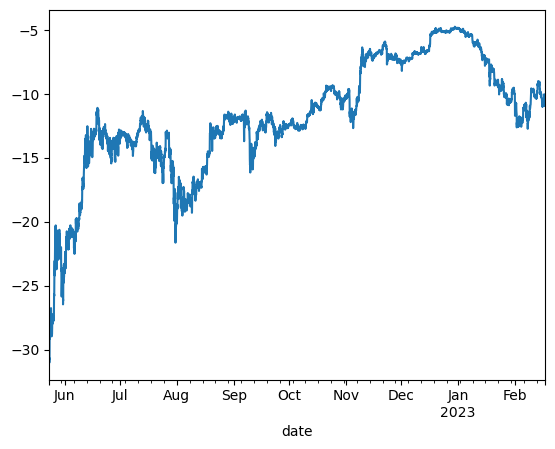

In [135]:
coint_series.plot()

<AxesSubplot:xlabel='date'>

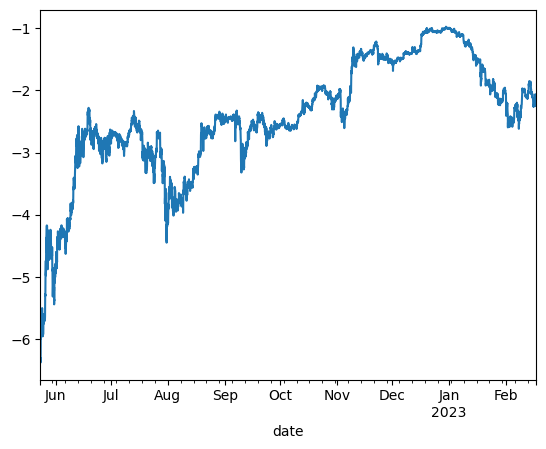

In [136]:
(rei-gal).plot()

<AxesSubplot:xlabel='date'>

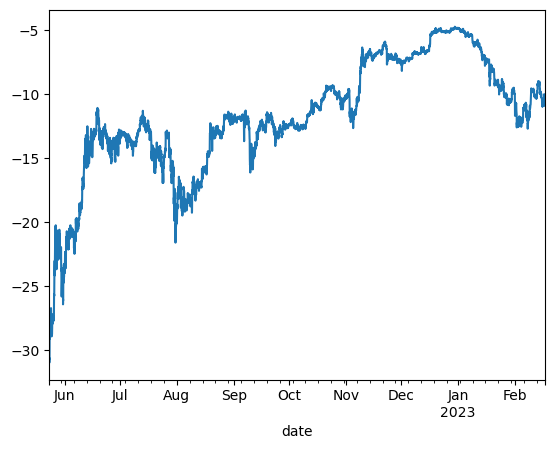

In [137]:
(beta * gal + (1-beta) * rei ).plot()

In the context of cointegration, beta refers to the coefficient of the linear combination of the two time series that results in a stationary series.

In the coint() function from the statsmodels.tsa.stattools module, the coefficient beta is obtained by fitting a linear regression model to the two input time series and taking the first element of the result. The resulting beta value can be used to calculate the cointegrated series as a linear combination of the input series.



## Spread:

The concept of the "spread" is commonly used in financial markets to find pairs of assets that are cointegrated. In the context of a pair of nonstationary time series, such as the log-prices of two stocks or two cryptocurrencies, it can be difficult to determine whether there is a long-term relationship between the two series. However, if there is a common trend that affects both series, we can use this to construct a stationary series that measures the deviation of one series from the other.

In the case of the log-prices of two cryptocurrencies, let's say BTC and ETH, we can define the spread as the difference between the log-price of BTC and a multiple of the log-price of ETH. Specifically, we can define:

```
zt = log(BTC/ETH) - gamma * log(ETH)
```

where gamma is a coefficient that determines the weight given to the log-price of ETH in the spread. If gamma is known, then we can use this formula to construct a stationary series zt that measures the deviation of the log-price of BTC from its expected value based on the log-price of ETH.

To estimate gamma, we can use regression analysis to fit the model:

```
log(BTC/ETH) = gamma * log(ETH) + epsilon
```

where epsilon is a random error term. The estimated value of gamma can then be used to construct the spread series zt.

<AxesSubplot:xlabel='date'>

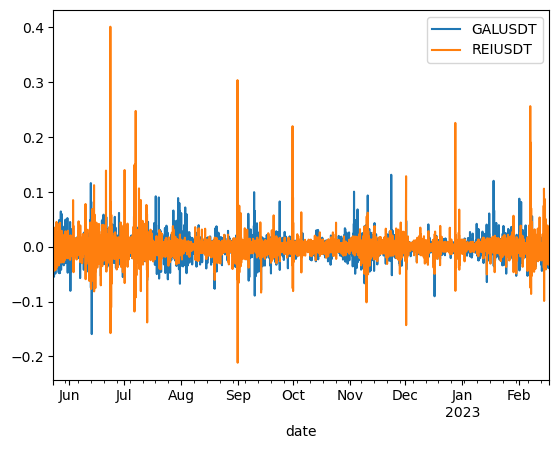

In [140]:
np.log(df).diff().plot()

In [150]:
returns = np.log(df).diff()
returns.dropna(inplace=True)

In [151]:
returns

,GALUSDT,REIUSDT
date,,
2022-05-23 13:00:00,0.003141,-0.009970
2022-05-23 14:00:00,-0.004242,0.000000
2022-05-23 15:00:00,0.012362,0.004000
2022-05-23 16:00:00,-0.003896,-0.004000
2022-05-23 17:00:00,-0.005793,-0.012097
...,...,...
2023-02-17 07:00:00,-0.003661,0.000000
2023-02-17 08:00:00,0.007764,0.007905
2023-02-17 09:00:00,-0.001366,-0.021221


In [154]:
model = sm.OLS(returns['REIUSDT'], sm.add_constant(returns['GALUSDT']))
result = model.fit()
gamma = result.params['GALUSDT']

In [155]:
gamma

0.32668225746199964

In [156]:
#spread
returns['GALUSDT'] - gamma * returns['REIUSDT']

date
2022-05-23 13:00:00    0.006398
2022-05-23 14:00:00   -0.004242
2022-05-23 15:00:00    0.011056
2022-05-23 16:00:00   -0.002589
2022-05-23 17:00:00   -0.001842
                         ...   
2023-02-17 07:00:00   -0.003661
2023-02-17 08:00:00    0.005182
2023-02-17 09:00:00    0.005567
2023-02-17 10:00:00    0.001270
2023-02-17 11:00:00    0.007704
Length: 6479, dtype: float64

<AxesSubplot:xlabel='date'>

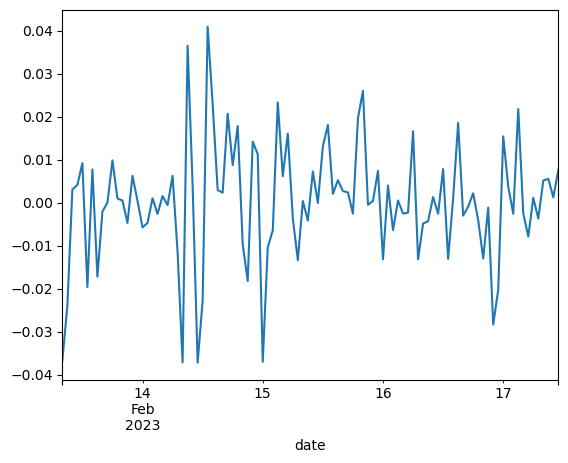

In [157]:
spread = returns['GALUSDT'] - gamma * returns['REIUSDT']
spread.tail(100).plot()

In [158]:
### spread calculated using pure numpy and pandas:

def add_ones(arr):
    return np.concatenate((np.ones((arr.shape[0], 1)), arr), axis=1)

X = add_ones(returns['GALUSDT'].values.reshape((-1, 1)))
y = returns['REIUSDT'].values.reshape((-1, 1))
beta = np.linalg.lstsq(X, y, rcond=None)[0]
gamma = beta[1][0]
gamma

0.32668225746199947

In [159]:
spread = returns['GALUSDT'] - gamma * returns['REIUSDT']
spread

date
2022-05-23 13:00:00    0.006398
2022-05-23 14:00:00   -0.004242
2022-05-23 15:00:00    0.011056
2022-05-23 16:00:00   -0.002589
2022-05-23 17:00:00   -0.001842
                         ...   
2023-02-17 07:00:00   -0.003661
2023-02-17 08:00:00    0.005182
2023-02-17 09:00:00    0.005567
2023-02-17 10:00:00    0.001270
2023-02-17 11:00:00    0.007704
Length: 6479, dtype: float64

<AxesSubplot:xlabel='date'>

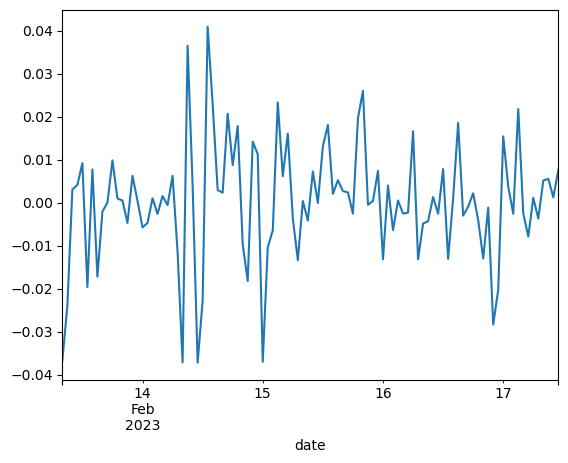

In [160]:
spread.tail(100).plot()

<AxesSubplot:xlabel='date'>

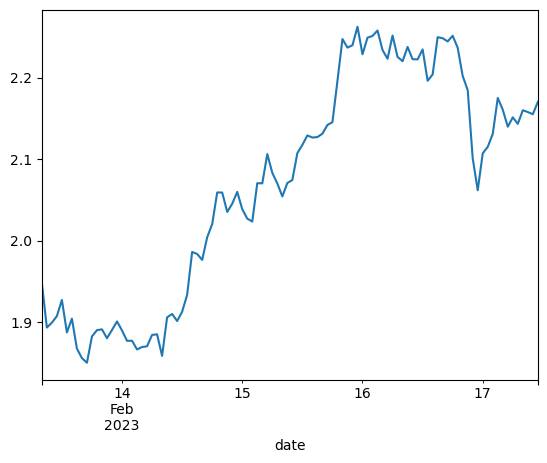

In [161]:
(gal-rei).tail(100).plot()

<AxesSubplot:xlabel='date'>

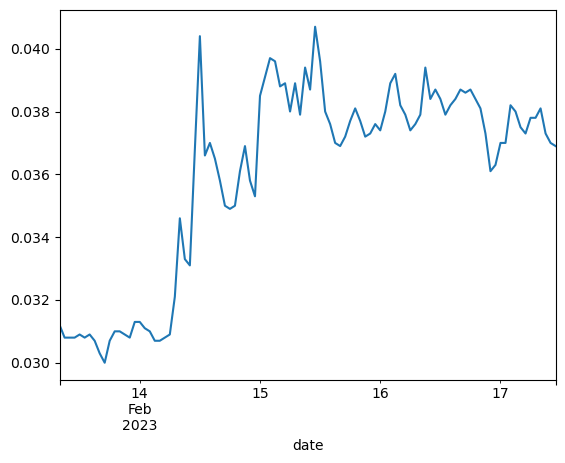

In [162]:
rei.tail(100).plot()

<AxesSubplot:xlabel='date'>

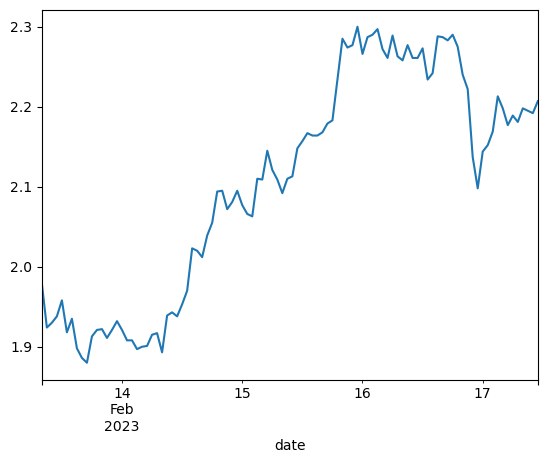

In [163]:
gal.tail(100).plot()

In [165]:
window =20
num_std = 2
df['diff_close'] = df['GALUSDT'] - df['REIUSDT']
df['spread'] = spread

roll_mean = df['spread'].rolling(window=window).mean()
roll_std = df['spread'].rolling(window=window).std()
z_score = (df['spread'] - roll_mean) / roll_std

df['z_score'] = z_score
#df['signal'] = 0

long_signals = (z_score < -num_std)
short_signals = (z_score > num_std)

df['long_signals'] = long_signals
df['short_signals'] = short_signals

df[df['short_signals'] == True]

,GALUSDT,REIUSDT,spread,z_score,long_signals,short_signals,diff_close
date,,,,,,,
2022-05-24 14:00:00,5.709,0.0437,0.042690,2.103620,False,True,5.6653
2022-05-26 14:00:00,5.024,0.0468,0.035201,2.288740,False,True,4.9772
2022-05-27 12:00:00,4.838,0.0453,0.065895,2.027367,False,True,4.7927
2022-05-30 01:00:00,4.800,0.0465,0.040277,2.351701,False,True,4.7535
2022-05-31 02:00:00,5.489,0.0478,0.046844,2.392372,False,True,5.4412
...,...,...,...,...,...,...,...
2023-02-08 21:00:00,2.405,0.0357,0.012479,2.030660,False,True,2.3693
2023-02-08 23:00:00,2.473,0.0358,0.017797,2.178752,False,True,2.4372
2023-02-10 05:00:00,2.036,0.0309,0.014903,2.020111,False,True,2.0051


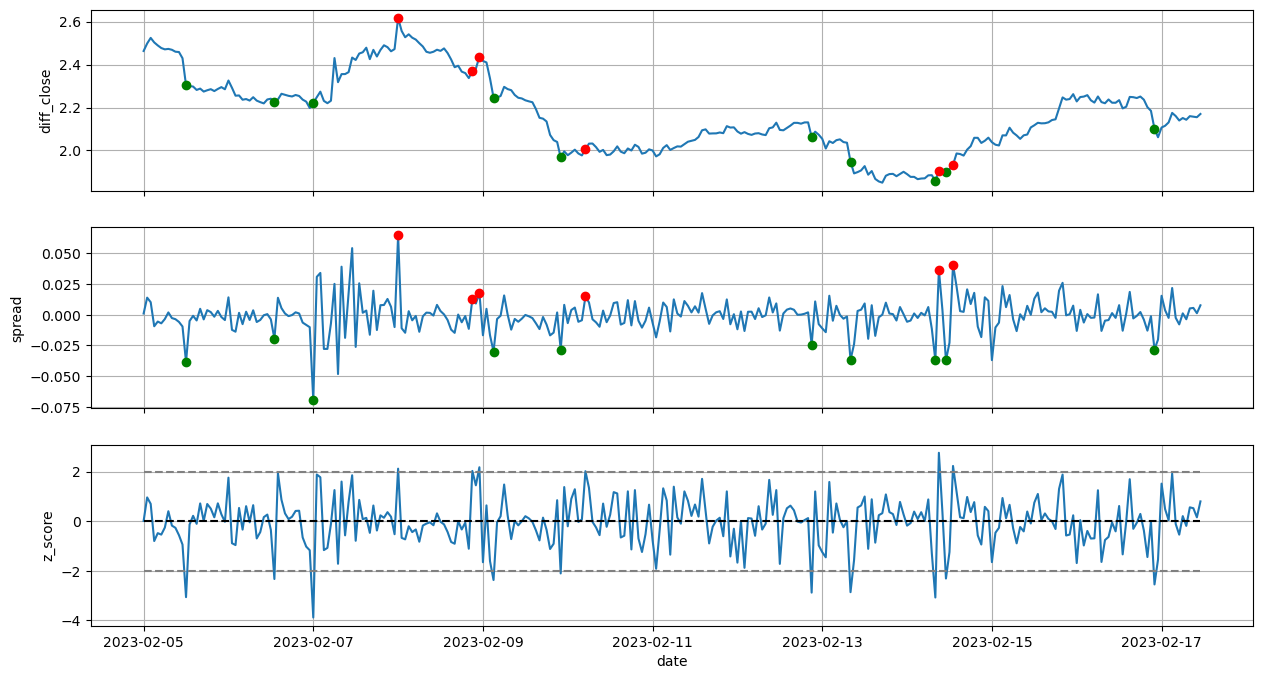

In [167]:
import matplotlib.pyplot as plt
import numpy as np

df = df.tail(300)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,8), sharex=True)

# plot for 'diff_close'
ax1.plot(df.index, df['diff_close'])
ax1.plot(df.index[df['long_signals']], df.loc[df['long_signals'], 'diff_close'], 'go')
ax1.plot(df.index[df['short_signals']], df.loc[df['short_signals'], 'diff_close'], 'ro')
ax1.set_ylabel('diff_close')
ax1.grid(True)

# plot for 'spread'
ax2.plot(df.index, df['spread'])
ax2.plot(df.index[df['long_signals']], df.loc[df['long_signals'], 'spread'], 'go')
ax2.plot(df.index[df['short_signals']], df.loc[df['short_signals'], 'spread'], 'ro')
ax2.set_ylabel('spread')
ax2.grid(True)

# plot for 'z_score'
ax3.plot(df.index, df['z_score'])
ax3.plot(df.index, np.zeros(len(df)), 'k--')
ax3.plot(df.index, np.full(len(df), 2), 'gray', linestyle='--')
ax3.plot(df.index, np.full(len(df), -2), 'gray', linestyle='--')
ax3.set_ylabel('z_score')
ax3.set_xlabel('date')
ax3.grid(True)

plt.show()


# Compiled

In [307]:
binance = ccxt.binance({'options': {'enableRateLimit': True}})
binance_perp = ccxt.binanceusdm({'options': {'enableRateLimit': True}})

pd.options.mode.chained_assignment = None 

exchange = ccxt.binance()
timeframe = '1h'

go_back = 0 # 0 for current, 1 for 30 days (1 month) back, 2 for 2 months back etc.
default_lookback = 9 # 9 for 10 months back and 1 month test set, 10 for 11 months back, etc.
months_back = default_lookback + (1*go_back) # 9 for 10 months back, 10 for 11 months back, etc.
days_back = 0 + (go_back*30) # 0 for today, 30 for 30 days back, etc.


def get_ohlcv_data(symbol, since, until):
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, since, until)
    return pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

def get_past_n_months_data(symbol, n_months):
    current_time = int(time.time() * 1000)
    past_n_months = current_time - (n_months * 30 * 24 * 60 * 60 * 1000)
    dfs = []
    for i in range(n_months, 0, -1):
        start = current_time - (i * 30 * 24 * 60 * 60 * 1000)
        end = current_time - ((i - 1) * 30 * 24 * 60 * 60 * 1000)
        df = get_ohlcv_data(symbol, start, end)
        dfs.append(df)
    return pd.concat(dfs)



#symbols = ['GALUSDT', 'REIUSDT']
symbols = ['ACHUSDT', 'KP3RUSDT']

dfs = []
for symbol in symbols:
    try:
        df = get_past_n_months_data(symbol, months_back)
        df = df[['timestamp', 'close']]
        df.rename(columns={'timestamp': 'date', 'close': symbol}, inplace=True)
        dfs.append(df)
    except Exception as e:
        print(f"Failed to retrieve data for {symbol}: {e}")

if dfs:
    d_=[]
    val = dfs.copy()

    for v in val:
            
        d = v.reset_index(drop=True)
        d_.append(d)

    df = pd.concat(d_, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.dropna(inplace=True)
    df = df[~df.date.duplicated(keep='first')]
    
df.set_index('date', inplace=True)
df
copy_df = df.copy()

In [308]:
prices_df = copy_df.copy()
prices_df 

,ACHUSDT,KP3RUSDT
date,,
2022-05-23 18:00:00,0.02131,152.91
2022-05-23 19:00:00,0.02059,147.77
2022-05-23 20:00:00,0.02086,145.87
2022-05-23 21:00:00,0.02136,147.85
2022-05-23 22:00:00,0.02117,143.99
...,...,...
2023-02-17 13:00:00,0.02216,82.98
2023-02-17 14:00:00,0.02294,82.70
2023-02-17 15:00:00,0.02256,83.56


In [310]:
df = prices_df.copy()

returns = np.log(df).diff()
returns.dropna(inplace=True)

window =20
num_std = 2

df['diff_close'] = df[f'{symbols[0]}'] - df[f'{symbols[1]}']

def add_ones(arr):
    return np.concatenate((np.ones((arr.shape[0], 1)), arr), axis=1)

X = add_ones(returns[f'{symbols[0]}'].values.reshape((-1, 1)))
y = returns[f'{symbols[1]}'].values.reshape((-1, 1))
beta = np.linalg.lstsq(X, y, rcond=None)[0]
gamma = beta[1][0]

spread = returns[f'{symbols[0]}'] - gamma * returns[f'{symbols[1]}']
df['spread'] = spread

roll_mean = df['spread'].rolling(window=window).mean()
roll_std = df['spread'].rolling(window=window).std()
z_score = (df['spread'] - roll_mean) / roll_std

df['z_score'] = z_score

# Resample to 4-hourly intervals
df_4h = df.resample('4H').last()
diff_close_4h = df_4h['diff_close']
roll_mean_4h = diff_close_4h.rolling(window=window).mean()
roll_std_4h = diff_close_4h.rolling(window=window).std()
upper_band = roll_mean_4h + num_std * roll_std_4h
lower_band = roll_mean_4h - num_std * roll_std_4h

# Add Bollinger bands to original dataframe
df['upper_band'] = upper_band.reindex(df.index, method='ffill')
df['lower_band'] = lower_band.reindex(df.index, method='ffill')
df['4h_mean'] = roll_mean_4h.reindex(df.index, method='ffill')

long_signals = (z_score < -num_std) & (df['diff_close']< df['lower_band'])
short_signals = (z_score > num_std) & (df['diff_close']> df['upper_band'])

df['long_signals'] = long_signals
df['short_signals'] = short_signals
df.dropna(inplace=True)
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2022-05-26 20:00:00,0.01755,128.04,-128.02245,0.001313,0.382050,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 21:00:00,0.01770,130.33,-130.31230,0.005028,0.492197,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 22:00:00,0.01766,129.01,-128.99234,-0.000263,0.278868,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 23:00:00,0.01743,126.92,-126.90257,-0.009901,-0.056019,-128.144801,-155.316393,-141.730597,False,False
2022-05-27 00:00:00,0.01748,126.25,-126.23252,0.003904,0.428358,-125.006158,-156.031308,-140.518733,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 13:00:00,0.02216,82.98,-82.95784,-0.026479,-0.751749,-72.954022,-85.436742,-79.195382,False,False
2023-02-17 14:00:00,0.02294,82.70,-82.67706,0.035257,0.908073,-72.954022,-85.436742,-79.195382,False,False
2023-02-17 15:00:00,0.02256,83.56,-83.53744,-0.018736,-0.565606,-72.954022,-85.436742,-79.195382,False,False


In [311]:
df.dropna(inplace=True)

In [312]:
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2022-05-26 20:00:00,0.01755,128.04,-128.02245,0.001313,0.382050,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 21:00:00,0.01770,130.33,-130.31230,0.005028,0.492197,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 22:00:00,0.01766,129.01,-128.99234,-0.000263,0.278868,-128.144801,-155.316393,-141.730597,False,False
2022-05-26 23:00:00,0.01743,126.92,-126.90257,-0.009901,-0.056019,-128.144801,-155.316393,-141.730597,False,False
2022-05-27 00:00:00,0.01748,126.25,-126.23252,0.003904,0.428358,-125.006158,-156.031308,-140.518733,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 13:00:00,0.02216,82.98,-82.95784,-0.026479,-0.751749,-72.954022,-85.436742,-79.195382,False,False
2023-02-17 14:00:00,0.02294,82.70,-82.67706,0.035257,0.908073,-72.954022,-85.436742,-79.195382,False,False
2023-02-17 15:00:00,0.02256,83.56,-83.53744,-0.018736,-0.565606,-72.954022,-85.436742,-79.195382,False,False


In [262]:
plot_df = df.copy()

In [263]:
x = plot_df.copy()

In [264]:
x

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2022-05-26 16:00:00,0.01891,132.94,-132.92109,0.011942,0.650740,-129.638596,-156.981177,-143.309887,False,False
2022-05-26 17:00:00,0.01854,132.40,-132.38146,-0.018960,-0.451420,-129.638596,-156.981177,-143.309887,False,False
2022-05-26 18:00:00,0.01766,128.83,-128.81234,-0.043257,-1.226602,-129.638596,-156.981177,-143.309887,False,False
2022-05-26 19:00:00,0.01750,127.04,-127.02250,-0.006352,0.124676,-129.638596,-156.981177,-143.309887,False,False
2022-05-26 20:00:00,0.01755,128.04,-128.02245,0.001312,0.382026,-128.144801,-155.316393,-141.730597,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 09:00:00,0.02203,82.30,-82.27797,0.034223,0.990283,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 10:00:00,0.02148,82.24,-82.21852,-0.025140,-0.649708,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 11:00:00,0.02173,82.41,-82.38827,0.011166,0.388638,-72.430243,-85.013237,-78.721740,False,False


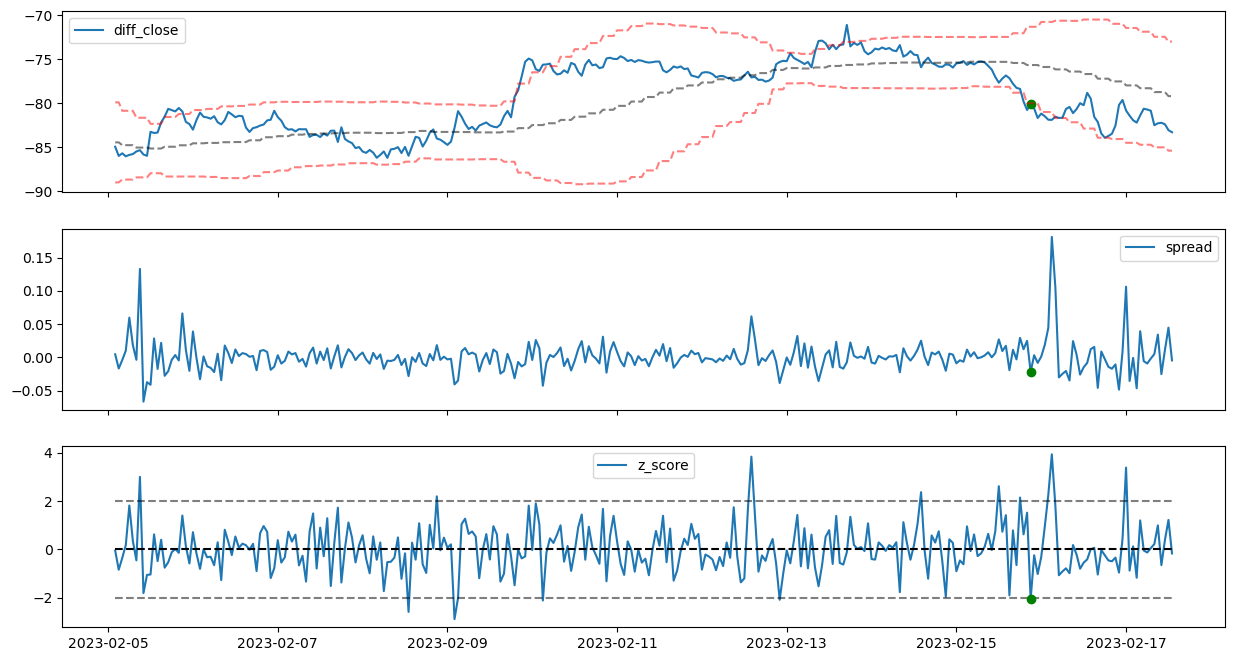

In [265]:
x = plot_df.copy()
#df = x.iloc[900:1350]
df = df.tail(300)
# Plot the data
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 8), sharex=True)

# Plot diff_close with long and short signals
ax1.plot(df.index, df['diff_close'], label='diff_close')
ax1.plot(df[df['long_signals']].index, df[df['long_signals']]['diff_close'], 'go')
ax1.plot(df[df['short_signals']].index, df[df['short_signals']]['diff_close'], 'ro')
ax1.legend()

# Plot spread with long and short signals
ax2.plot(df.index, df['spread'], label='spread')
ax2.plot(df[df['long_signals']].index, df[df['long_signals']]['spread'], 'go')
ax2.plot(df[df['short_signals']].index, df[df['short_signals']]['spread'], 'ro')
ax2.legend()

# Plot z_score with long and short signals
ax3.plot(df.index, df['z_score'], label='z_score')
ax3.plot(df['z_score'].index, np.zeros(len(df)), 'k--')
ax3.plot(df['z_score'].index, np.ones(len(df)) * num_std, 'k--', alpha=0.5)
ax3.plot(df['z_score'].index, np.ones(len(df)) * (-num_std), 'k--', alpha=0.5)
ax3.plot(df[df['long_signals']].index, df[df['long_signals']]['z_score'], 'go')
ax3.plot(df[df['short_signals']].index, df[df['short_signals']]['z_score'], 'ro')
ax3.legend()

# Plot Bollinger bands on diff_close plot
ax1.plot(df.index, df['upper_band'], 'r--', alpha=0.5)
ax1.plot(df.index, df['lower_band'], 'r--', alpha=0.5)
ax1.plot(df.index, df['4h_mean'], 'k--', alpha=0.5)

plt.show()


In [266]:
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2023-02-05 02:00:00,0.01762,84.96,-84.94238,0.004611,-0.050437,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 03:00:00,0.01737,86.01,-85.99263,-0.016704,-0.840835,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 04:00:00,0.01729,85.71,-85.69271,-0.003930,-0.355701,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 05:00:00,0.01748,86.05,-86.03252,0.010151,0.180007,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 06:00:00,0.01855,85.89,-85.87145,0.059778,1.812956,-80.852204,-88.682404,-84.767304,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 09:00:00,0.02203,82.30,-82.27797,0.034223,0.990283,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 10:00:00,0.02148,82.24,-82.21852,-0.025140,-0.649708,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 11:00:00,0.02173,82.41,-82.38827,0.011166,0.388638,-72.430243,-85.013237,-78.721740,False,False


## Ornstein Uhlenbeck Process
>
The Ornstein-Uhlenbeck (OU) process is a stochastic process commonly used in finance to model the behavior of asset prices and interest rates over time. One of the advantages of using the OU process is its ability to model mean-reverting behavior, which is often observed in financial markets.

When modeling the mispricing between two assets, the OU process can be used to capture the tendency of the mispricing to revert back to its mean over time. This is because the OU process is a continuous-time process that is capable of modeling the random fluctuations of an asset price around a long-term mean value.

In particular, the OU process is a useful tool for modeling the spread between two assets, such as a stock and a related futures contract or two similar securities with different prices. The spread between these two assets can be modeled as an OU process, where the process mean represents the long-term equilibrium value of the spread, and the mean reversion parameter determines how quickly the spread reverts to this long-term mean after a deviation.

Overall, using the OU process to model the mispricing between two assets can help to capture the statistical properties of the spread and provide valuable insights into the behavior of financial markets.

In [293]:
from scipy.optimize import minimize

def ou_likelihood(params, spread):
    mu, theta, sigma = params
    T = len(spread)
    S = np.zeros(T)
    S[0] = spread[0]
    v = np.zeros(T)
    v[0] = np.var(spread)
    for t in range(1, T):
        S[t] = S[t-1] + theta * (mu - S[t-1]) + sigma * np.random.normal()
        v[t] = np.var(spread[:t+1] - S[:t+1])
    ll = np.sum(-0.5 * (spread - S)**2 / v - 0.5 * np.log(2 * np.pi * v))
    return -ll

spread = df['spread'].values
result = minimize(ou_likelihood, (np.mean(spread), 0.01, np.std(spread)), args=(spread,))
mu, theta, sigma = result.x
print(mu, theta, sigma)

def simulate_ou_process(mu, theta, sigma, S0, T, dt):
    t = np.arange(0, T, dt)
    S = np.zeros_like(t)
    S[0] = S0
    for i in range(1, len(t)):
        S[i] = S[i-1] + theta * (mu - S[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return S


0.0008681611468802071 0.009999996143346825 0.02318489652504355


In [287]:
print(mu, theta, sigma)

0.0008681652178338085 0.5 0.023184903531267374


In [288]:
S0 = spread[-1]
T = 30 #1 # 1 day
dt = 1/24 #1/288 # 5 minutes
ou_sim = simulate_ou_process(mu, theta, sigma, S0, T, dt)



In [289]:
new_spread = np.diff(ou_sim) + spread[-1]


In [290]:
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2023-02-05 02:00:00,0.01762,84.96,-84.94238,0.004611,-0.050437,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 03:00:00,0.01737,86.01,-85.99263,-0.016704,-0.840835,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 04:00:00,0.01729,85.71,-85.69271,-0.003930,-0.355701,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 05:00:00,0.01748,86.05,-86.03252,0.010151,0.180007,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 06:00:00,0.01855,85.89,-85.87145,0.059778,1.812956,-80.852204,-88.682404,-84.767304,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 09:00:00,0.02203,82.30,-82.27797,0.034223,0.990283,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 10:00:00,0.02148,82.24,-82.21852,-0.025140,-0.649708,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 11:00:00,0.02173,82.41,-82.38827,0.011166,0.388638,-72.430243,-85.013237,-78.721740,False,False


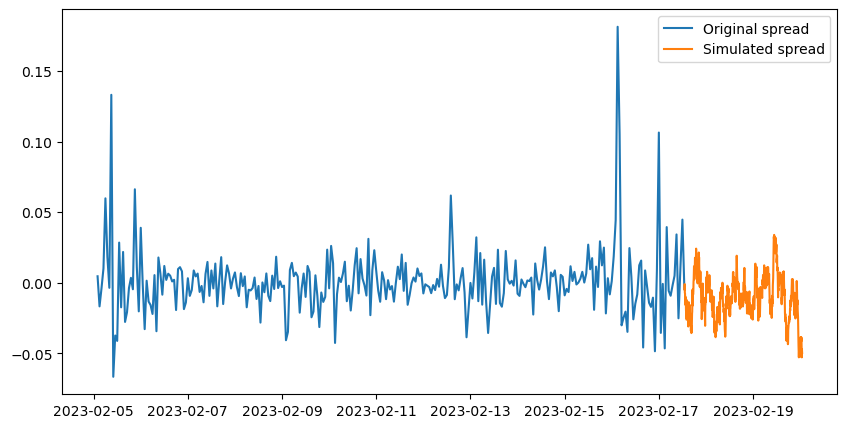

In [291]:
import matplotlib.pyplot as plt

df = df.tail(300)

plt.figure(figsize=(10,5))
plt.plot(df.index, df['spread'], label='Original spread')
simulated_index = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=5), freq='5T', periods=len(ou_sim))
simulated_spread = pd.Series(ou_sim, index=simulated_index)
plt.plot(simulated_spread.index, simulated_spread, label='Simulated spread')
plt.legend()
plt.show()


# Shumway Stoffer Smoother

The Shumway Stoffer Smoother is a statistical method used for time series data analysis. It is particularly useful for smoothing out noisy data and identifying underlying trends in a time series. To use the Shumway Stoffer Smoother to generate signals for trading, you can follow these general steps:

Gather data: Collect time series data on the asset or financial instrument you are interested in trading. This could be stock prices, currency exchange rates, or any other relevant data.

Preprocess data: Before applying the Shumway Stoffer Smoother, it is important to preprocess the data to remove any outliers or other anomalies that could skew the results. This could involve identifying and removing missing data points, removing extreme values, or other data cleaning tasks.

Apply the Shumway Stoffer Smoother: Once the data has been preprocessed, you can apply the Shumway Stoffer Smoother to the time series data. This will generate a smoothed version of the data that highlights underlying trends and removes noise.

Analyze the smoothed data: After applying the Shumway Stoffer Smoother, you can analyze the smoothed data to identify trading signals. For example, you could look for upward or downward trends, moving averages, or other patterns that suggest the asset is likely to rise or fall in value.

Use trading indicators: You can use the trading signals generated by the smoothed data as input to trading indicators, such as moving averages or oscillators. These indicators can provide additional insights into the market and help you make more informed trading decisions.

Monitor and adjust: It is important to monitor the market and adjust your trading strategies as needed based on new data and market conditions.

Overall, the Shumway Stoffer Smoother can be a useful tool for generating trading signals, but it should be used in conjunction with other technical and fundamental analysis methods to get a more comprehensive view of the market.


In [294]:
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals
date,,,,,,,,,,
2023-02-05 02:00:00,0.01762,84.96,-84.94238,0.004611,-0.050437,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 03:00:00,0.01737,86.01,-85.99263,-0.016704,-0.840835,-79.892089,-89.003992,-84.448041,False,False
2023-02-05 04:00:00,0.01729,85.71,-85.69271,-0.003930,-0.355701,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 05:00:00,0.01748,86.05,-86.03252,0.010151,0.180007,-80.852204,-88.682404,-84.767304,False,False
2023-02-05 06:00:00,0.01855,85.89,-85.87145,0.059778,1.812956,-80.852204,-88.682404,-84.767304,False,False
...,...,...,...,...,...,...,...,...,...,...
2023-02-17 09:00:00,0.02203,82.30,-82.27797,0.034223,0.990283,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 10:00:00,0.02148,82.24,-82.21852,-0.025140,-0.649708,-72.430243,-85.013237,-78.721740,False,False
2023-02-17 11:00:00,0.02173,82.41,-82.38827,0.011166,0.388638,-72.430243,-85.013237,-78.721740,False,False


In [296]:
import statsmodels.api as sm

# Assuming your DataFrame is named `df`
# Convert the date index to datetime
df.index = pd.to_datetime(df.index)

# Create the SARIMAX model
model = sm.tsa.statespace.SARIMAX(df['spread'], order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))

# Fit the model to the data
results = model.fit()

# Get the smoothed data from the fitted model
df['smoothed_data'] = results.predict(start=df.index[0], end=df.index[-1])

# Calculate the difference between the smoothed data and the original data
df['smoothed_diff'] = df['spread'] - df['smoothed_data']
df

/Users/royceantonjose/opt/anaconda3/envs/trading/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/royceantonjose/opt/anaconda3/envs/trading/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02942D+00    |proj g|=  1.00732D+01

At iterate    5    f= -2.06092D+00    |proj g|=  4.87229D-01

At iterate   10    f= -2.06609D+00    |proj g|=  1.22417D+00

At iterate   15    f= -2.06634D+00    |proj g|=  5.70523D-03

At iterate   20    f= -2.06635D+00    |proj g|=  1.57080D-02

At iterate   25    f= -2.06636D+00    |proj g|=  9.35828D-02

At iterate   30    f= -2.06639D+00    |proj g|=  3.12996D-01

At iterate   35    f= -2.06652D+00    |proj g|=  1.22676D+00

At iterate   40    f= -2.06787D+00    |proj g|=  4.20953D-01

At iterate   45    f= -2.06797D+00    |proj g|=  1.10233D-02
  ys=-5.657E-12  -gs= 2.687E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/royceantonjose/opt/anaconda3/envs/trading/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46    130      2     1     0   1.102D-02  -2.068D+00
  F =  -2.0679690119792871     

ABNORMAL_TERMINATION_IN_LNSRCH                              


,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals,smoothed_data,smoothed_diff
date,,,,,,,,,,,,
2023-02-05 02:00:00,0.01762,84.96,-84.94238,0.004611,-0.050437,-79.892089,-89.003992,-84.448041,False,False,0.000000e+00,0.004611
2023-02-05 03:00:00,0.01737,86.01,-85.99263,-0.016704,-0.840835,-79.892089,-89.003992,-84.448041,False,False,4.778578e-13,-0.016704
2023-02-05 04:00:00,0.01729,85.71,-85.69271,-0.003930,-0.355701,-80.852204,-88.682404,-84.767304,False,False,-1.680081e-12,-0.003930
2023-02-05 05:00:00,0.01748,86.05,-86.03252,0.010151,0.180007,-80.852204,-88.682404,-84.767304,False,False,-5.859719e-13,0.010151
2023-02-05 06:00:00,0.01855,85.89,-85.87145,0.059778,1.812956,-80.852204,-88.682404,-84.767304,False,False,9.895600e-13,0.059778
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 09:00:00,0.02203,82.30,-82.27797,0.034223,0.990283,-72.430243,-85.013237,-78.721740,False,False,9.295593e-03,0.024927
2023-02-17 10:00:00,0.02148,82.24,-82.21852,-0.025140,-0.649708,-72.430243,-85.013237,-78.721740,False,False,1.150462e-03,-0.026290
2023-02-17 11:00:00,0.02173,82.41,-82.38827,0.011166,0.388638,-72.430243,-85.013237,-78.721740,False,False,-1.007989e-02,0.021246


In this example, we assume that the 'ACHUSDT' column contains the time series data that you want to smooth. We specify the order and seasonal_order parameters for the SARIMAX model to control the smoothing process. In this case, we use an order of (1, 0, 0) and a seasonal order of (0, 1, 1, 24) to capture the daily seasonal trend.

Once we have fitted the SARIMAX model to the data, we can use the predict method to get the smoothed data for the entire time range of the DataFrame. We then store this smoothed data in a new column named 'smoothed_data'. Finally, we calculate the difference between the smoothed data and the original data, and store it in a new column named 'smoothed_diff'.

To generate trading signals, you can use the 'smoothed_diff' column and apply your own technical analysis methods or trading strategies to it. For example, you could use moving averages or other indicators to identify trends and generate buy or sell signals based on the smoothed data.





<AxesSubplot:xlabel='date'>

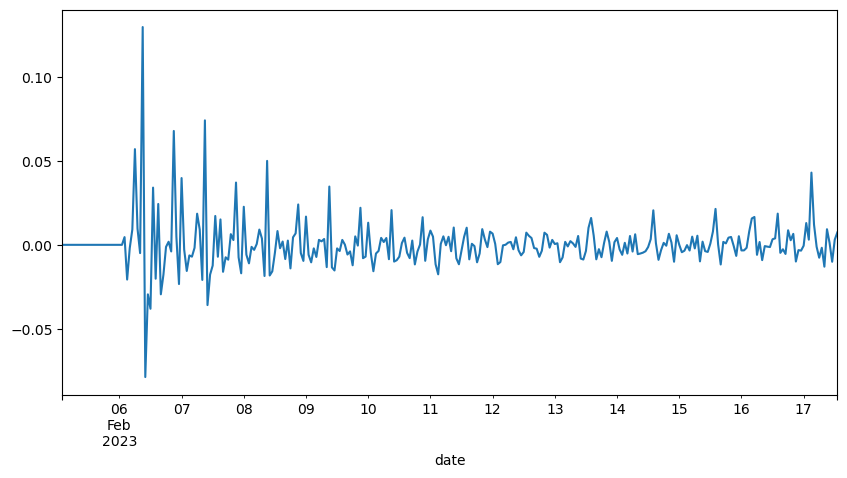

In [297]:
df.smoothed_data.plot(figsize=(10,5))

<AxesSubplot:xlabel='date'>

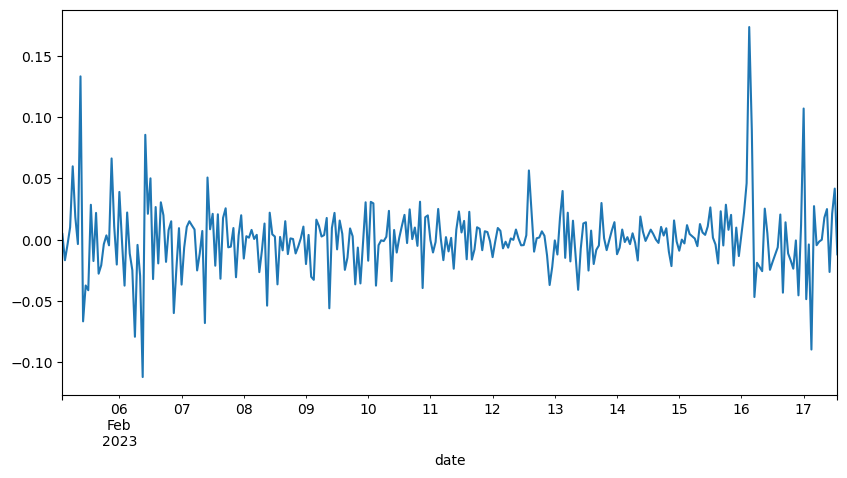

In [298]:
df.smoothed_diff.plot(figsize=(10,5))

<AxesSubplot:xlabel='date'>

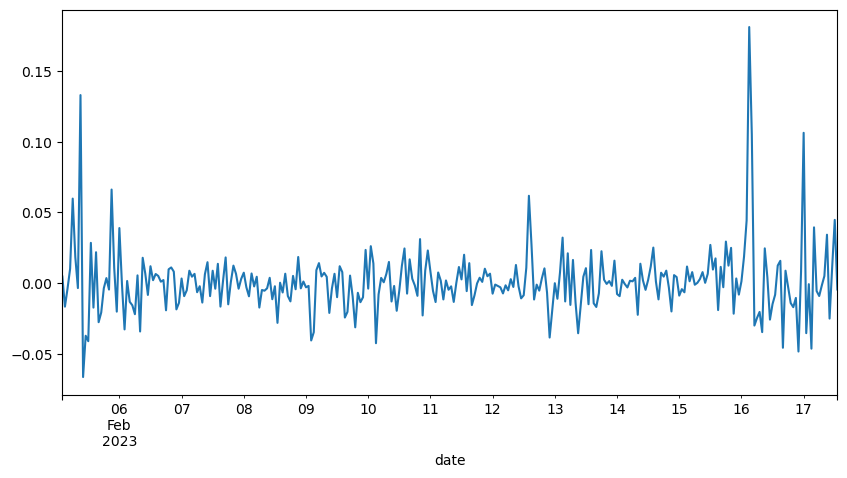

In [299]:
df.spread.plot(figsize=(10,5))

In [313]:
import numpy as np

def kalman_smoother(y, A, C, Q, R, mu0, V0):
    n = y.shape[0]
    m = mu0.shape[0]
    x = np.zeros((n, m))
    V = np.zeros((n, m, m))
    x[0] = mu0
    V[0] = V0
    for i in range(1, n):
        x_pred = A @ x[i-1]
        V_pred = A @ V[i-1] @ A.T + Q
        y_pred = C @ x_pred
        e = y[i] - y_pred
        S = C @ V_pred @ C.T + R
        K = V_pred @ C.T @ np.linalg.inv(S)
        x[i] = x_pred + K @ e
        V[i] = V_pred - K @ S @ K.T
    for i in range(n-2, -1, -1):
        J = V[i] @ A.T @ np.linalg.inv(V[i+1])
        x[i] = x[i] + J @ (x[i+1] - A @ x[i])
        V[i] = V[i] + J @ (V[i+1] - V[i]) @ J.T
    return x, V


<AxesSubplot:xlabel='t'>

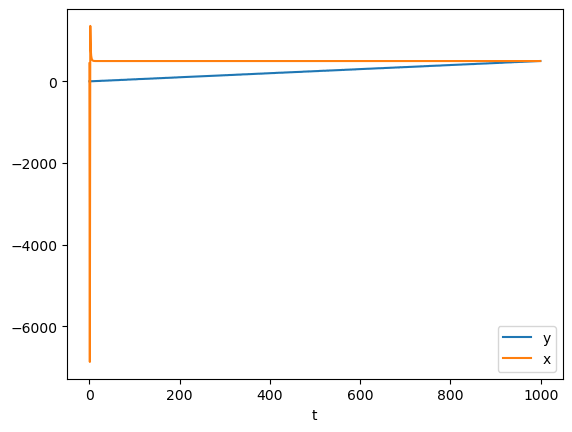

In [306]:
# Generate sample data
np.random.seed(0)
n = 1000
t = np.arange(n)
y = 0.5*t + np.random.normal(size=n)

# Define Kalman filter parameters
A = np.array([[1]])
C = np.array([[1]])
Q = np.array([[0.1]])
R = np.array([[1]])
mu0 = np.array([0])
V0 = np.array([[1]])

# Smooth the spread using the Kalman filter
x, V = kalman_smoother(y, A, C, Q, R, mu0, V0)

# Plot the results
df = pd.DataFrame({'t': t, 'y': y, 'x': x.flatten()})
df.set_index('t').plot()


In [318]:
# Define the parameters for the Kalman filter
dt = 1
A = np.array([[1, dt], [0, 1]])
C = np.array([[1, 0]])
Q = np.array([[0.05, 0], [0, 0.1]])
R = np.array([[1]])
mu0 = np.array([0, 0])
V0 = np.eye(2)

kalman_result = kalman_smoother(df['spread'].values, A, C, Q, R, mu0, V0)

x = kalman_result[0][:, 0]
V = kalman_result[1][:, 0, 0]

array([ 7.88523911e+01,  9.50042697e+00,  5.68508203e+00, ...,
        2.08342476e-02,  1.24603465e-02, -4.97384188e-03])

The x array returned by the Kalman filter represents the filtered state estimates, or in other words, the estimated values of the latent variables at each time step given the observations up to that point.

The V array represents the error covariance matrix for the state estimates. It contains information about the uncertainty or confidence in the state estimates at each time step.

The output of the Kalman smoother function is a tuple containing two arrays, x and V. The error you encountered suggests that you are trying to access a tuple using a slice instead of an integer index. To access the first column of x, you can use kalman_result[0][:, 0].

The variable x contains the smoothed state estimates, while the variable V contains the smoothed state covariances. In this case, x corresponds to the smoothed data, while V corresponds to the smoothed difference. The reason for this is that x represents the estimated true value of the state variable at each time step, while V represents the uncertainty or error in the estimation of the state variable at each time step. So, the smoothed data is given by x[:, 0], which extracts the first column of x, and the smoothed difference is given by x[:, 1], which extracts the second column of x.

In [322]:
x[:, 0] # smoothed data

array([  442.12483133, -6876.51776822,  1358.85698385,   784.72737526,
         625.57591972,   560.45634155,   529.82837611,   514.52470752,
         506.63775624,   502.51037548,   500.33377687,   499.18088462,
         498.56931579,   498.2443376 ,   498.07147672,   497.97952245,
         497.93059588,   497.90457814,   497.89072689,   497.88335576,
         497.87943064,   497.87733894,   497.87622667,   497.87563518,
         497.8753203 ,   497.87515297,   497.87506383,   497.8750164 ,
         497.87499116,   497.87497774,   497.87497061,   497.87496681,
         497.87496479,   497.87496371,   497.87496314,   497.87496283,
         497.87496267,   497.87496258,   497.87496254,   497.87496251,
         497.8749625 ,   497.87496249,   497.87496249,   497.87496249,
         497.87496249,   497.87496249,   497.87496249,   497.87496249,
         497.87496249,   497.87496249,   497.87496249,   497.87496249,
         497.87496249,   497.87496249,   497.87496249,   497.87496249,
      

In [325]:
#x[:, 1] # smoothed trend
kalman_result[0][:, 0] # smoothed difference

array([ 7.88523911e+01,  9.50042697e+00,  5.68508203e+00, ...,
        2.08342476e-02,  1.24603465e-02, -4.97384188e-03])

In [326]:
df['smoothed'] = kalman_result[0][:, 0]

In [327]:
df

,ACHUSDT,KP3RUSDT,diff_close,spread,z_score,upper_band,lower_band,4h_mean,long_signals,short_signals,smoothed
date,,,,,,,,,,,
2022-05-26 20:00:00,0.01755,128.04,-128.02245,0.001313,0.382050,-128.144801,-155.316393,-141.730597,False,False,78.852391
2022-05-26 21:00:00,0.01770,130.33,-130.31230,0.005028,0.492197,-128.144801,-155.316393,-141.730597,False,False,9.500427
2022-05-26 22:00:00,0.01766,129.01,-128.99234,-0.000263,0.278868,-128.144801,-155.316393,-141.730597,False,False,5.685082
2022-05-26 23:00:00,0.01743,126.92,-126.90257,-0.009901,-0.056019,-128.144801,-155.316393,-141.730597,False,False,-128.986852
2022-05-27 00:00:00,0.01748,126.25,-126.23252,0.003904,0.428358,-125.006158,-156.031308,-140.518733,False,False,-13.255041
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 13:00:00,0.02216,82.98,-82.95784,-0.026479,-0.751749,-72.954022,-85.436742,-79.195382,False,False,0.019809
2023-02-17 14:00:00,0.02294,82.70,-82.67706,0.035257,0.908073,-72.954022,-85.436742,-79.195382,False,False,0.012187
2023-02-17 15:00:00,0.02256,83.56,-83.53744,-0.018736,-0.565606,-72.954022,-85.436742,-79.195382,False,False,0.020834


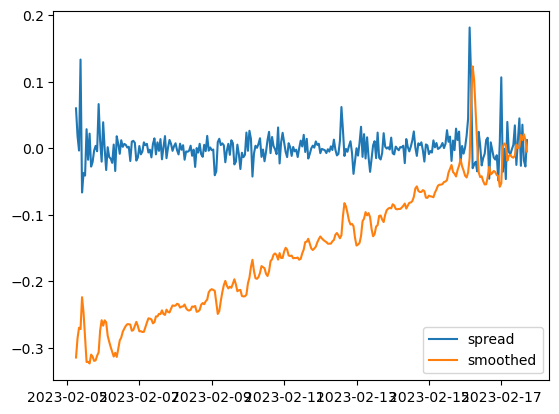

In [329]:
# Plot the spread and smoothed data
df_plot = df.copy()
df_plot = df_plot.tail(300)
plt.plot(df_plot.index, df_plot['spread'], label='spread')
plt.plot(df_plot.index, df_plot['smoothed'], label='smoothed')
plt.legend()
plt.show()

The level of smoothing depends on the values you use for Q and R in your Kalman filter. A smaller value of Q (process noise covariance matrix) will result in a smoother output. Similarly, a smaller value of R (measurement noise covariance matrix) will also result in a smoother output.

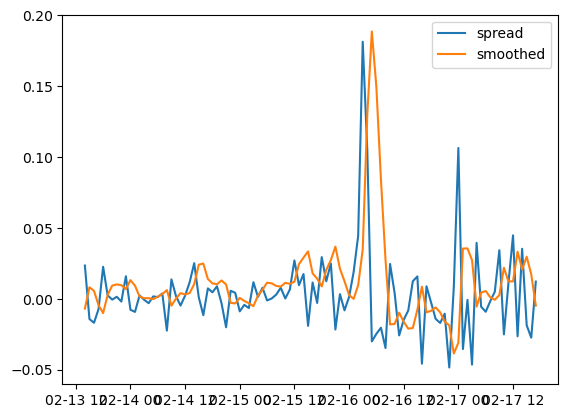

In [357]:
#You can try decreasing the values of Q and R to get a smoother output.
#Q = np.array([[0.01, 0], [0, 0.05]])
#R = np.array([[0.5]])

Q = np.array([[0.0001, 0], [0, 0.0005]])
R = np.array([[0.003]])


# Define the parameters for the Kalman filter
dt = 1
A = np.array([[1, dt], [0, 1]])
C = np.array([[1, 0]])
#Q = np.array([[0.05, 0], [0, 0.1]])
#R = np.array([[1]])
mu0 = np.array([0, 0])
V0 = np.eye(2)

kalman_result = kalman_smoother(df['spread'].values, A, C, Q, R, mu0, V0)

x = kalman_result[0][:, 0]
V = kalman_result[1][:, 0, 0]

#x[:, 0]
df['smoothed'] = kalman_result[0][:, 0]

df_plot = df.copy()
df_plot = df_plot.tail(100)
plt.plot(df_plot.index, df_plot['spread'], label='spread')
plt.plot(df_plot.index, df_plot['smoothed'], label='smoothed')
plt.legend()
plt.show()
